# Neural Network

Used a sequential model with two hiden layers and tested different number of neurons in each one. Used the Adam Optimizer, "binary_crossentropy" as loss function, ReLU activation function and the default 0.5 threshold in the classification


Useful links:

- [creating a neural network](https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/)

- [choosing number of layers](https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/)

- [How to choose loss functions](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

- [Adam Optimization](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

sns.set_palette("Blues")

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model

In [30]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)


    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d',cmap="Blues")
    plt.show()

    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')


    cm_normalized_matrix = pd.DataFrame(data=cm_normalized, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

    sns.heatmap(cm_normalized_matrix, annot=True, fmt='.3f',cmap="Blues")
    plt.show()

In [5]:
def get_metrics(y_test,y_pred):
    print("Accuracy: ", round(accuracy_score(y_test,y_pred),4))
    print("F1 score: ", round(f1_score(y_test,y_pred),4))
    print("Recall: ", round(recall_score(y_test,y_pred),4))
    print("Precision: ", round(precision_score(y_test,y_pred),4))

In [6]:
# auxiliar dfs

def get_nn(X, y, title):
  ncols = X.shape[1]

  # aux lists
  train_acc = []
  neuronsFirstLayer = []
  neuronsSecondLayer = []

  # number of neurons to test in the hidden layers
  firstLayer = [4,8,16,32,64,128]
  secondLayer = [4,8,16,32,64,128]
  kfold = KFold(n_splits=5, shuffle=True, random_state=42)

  # Save better model (accuracy)
  ckpt_model = f'{title}.hdf5'
  checkpoint = ModelCheckpoint(ckpt_model, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
  stop = EarlyStopping(monitor='loss', patience=8,verbose=0)
  callbacks_list = [stop, checkpoint]
  
  for f in firstLayer:
    for s in secondLayer:
      accuracy = []
      neuronsFirstLayer.append(f)
      neuronsSecondLayer.append(s)
      print(f"{f} neurons on first layer and {s} on second layer")
      for train, test in kfold.split(X, y):
        
        # create model with two hidden layers
        model = Sequential()
        model.add(Dense(f, input_shape=(ncols,), activation='relu'))
        model.add(Dense(s, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 
        history = model.fit(X[train], y[train],
          epochs=150,
          validation_data=(X[test], y[test]),
          batch_size=20,
          callbacks=callbacks_list,
          verbose=0)

        # evaluate the model
        scores = model.evaluate(X[test], y[test], verbose=0)#Returns the loss value[0] & metrics[1] values for the model in test mode.
        
        # accuracy
        accuracy.append(np.mean(scores[1]))
        
      # mean accuracy for the combination of f and s neurons
      train_acc.append(np.mean(accuracy))

      print(f'accuracy of: {round(scores[1],3)} for {f} and {s} neurons (1st and 2nd layer)')


  df =pd.DataFrame()
  df['accuracy']=train_acc
  df['neurons_1st']=neuronsFirstLayer
  df['neurons_2nd']=neuronsSecondLayer

  return df

## Load data

In [7]:
ssa_l20_n5 = pd.read_csv("C:\\Users\\julia\\Documents\\UNICAMP\\TCC\\Final_datasets\\ssa_l20_n5.csv")

### Sanity checks

In [8]:
ssa_l20_n5['label'].value_counts()

label
1    8316
0    1920
Name: count, dtype: int64

In [9]:
ssa_l20_n5['bearing'].value_counts()

bearing
K001    320
K002    320
KI18    320
KI17    320
KI16    320
KI14    320
KI04    320
KB27    320
KB24    320
KB23    320
KA30    320
KA22    320
KA16    320
KA15    320
KA04    320
KI08    320
KI07    320
KI05    320
KI03    320
KI01    320
KA09    320
KA07    320
KA06    320
KA05    320
KA03    320
KA01    320
K006    320
K005    320
K004    320
K003    320
KI21    320
KA08    316
Name: count, dtype: int64

In [10]:
ssa_l20_n5.columns

Index(['min_phase_current_1_ssa_0', 'max_phase_current_1_ssa_0',
       'median_phase_current_1_ssa_0', 'mean_phase_current_1_ssa_0',
       'rms_phase_current_1_ssa_0', 'std_phase_current_1_ssa_0',
       'range_phase_current_1_ssa_0', 'min_phase_current_2_ssa_0',
       'max_phase_current_2_ssa_0', 'median_phase_current_2_ssa_0',
       ...
       'rms_vibration_ssa_4', 'std_vibration_ssa_4', 'range_vibration_ssa_4',
       'rotation_speed', 'load_torque', 'radial_force', 'bearing', 'label',
       'label_detailed', 'category'],
      dtype='object', length=112)

## Split train and test

In [11]:
# keep samples of the same configuration in the train or test df
unique_cat = ssa_l20_n5["category"].unique()
train_ids, test_ids = train_test_split(unique_cat, test_size=0.33, random_state=42)

train_df = ssa_l20_n5[ssa_l20_n5["category"].isin(train_ids)]
test_df = ssa_l20_n5[ssa_l20_n5["category"].isin(test_ids)]

## Using phase current data

In [12]:
# Split train and test
X_train_current = train_df.filter(like="current")
X_test_current = test_df.filter(like="current")

y_train_current = train_df['label'].values
y_test_current = test_df['label'].values

# scaler
scaler = StandardScaler()

X_train_current = scaler.fit_transform(X_train_current)

X_test_current = scaler.transform(X_test_current)

In [13]:
# get best combination of number of neurons
title_best_current = "ssa_l20_n5_current"
best_current = get_nn(X_train_current,y_train_current,title_best_current)

4 neurons on first layer and 4 on second layer


c:\Users\julia\.julia\conda\3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


accuracy of: 0.99 for 4 and 4 neurons (1st and 2nd layer)
4 neurons on first layer and 8 on second layer
accuracy of: 1.0 for 4 and 8 neurons (1st and 2nd layer)
4 neurons on first layer and 16 on second layer
accuracy of: 0.998 for 4 and 16 neurons (1st and 2nd layer)
4 neurons on first layer and 32 on second layer
accuracy of: 0.997 for 4 and 32 neurons (1st and 2nd layer)
4 neurons on first layer and 64 on second layer
accuracy of: 0.981 for 4 and 64 neurons (1st and 2nd layer)
4 neurons on first layer and 128 on second layer
accuracy of: 0.996 for 4 and 128 neurons (1st and 2nd layer)
8 neurons on first layer and 4 on second layer
accuracy of: 0.996 for 8 and 4 neurons (1st and 2nd layer)
8 neurons on first layer and 8 on second layer
accuracy of: 0.998 for 8 and 8 neurons (1st and 2nd layer)
8 neurons on first layer and 16 on second layer
accuracy of: 0.996 for 8 and 16 neurons (1st and 2nd layer)
8 neurons on first layer and 32 on second layer
accuracy of: 0.999 for 8 and 32 neur

In [14]:
best_current.sort_values('accuracy',ascending=False).head()

,accuracy,neurons_1st,neurons_2nd
34,0.998824,128,64
27,0.998824,64,32
29,0.998676,64,128
33,0.998382,128,32
9,0.998382,8,32


### Results of the best estimator

In [31]:
model_current = load_model(f"{title_best_current}.hdf5")

y_pred_current = model_current.predict(X_test_current) > 0.5

print(classification_report(y_test_current, y_pred_current))

108/108 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       720
           1       0.95      0.99      0.97      2716

    accuracy                           0.95      3436
   macro avg       0.95      0.90      0.92      3436
weighted avg       0.95      0.95      0.95      3436



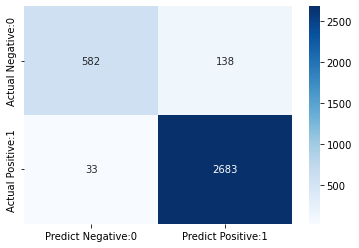

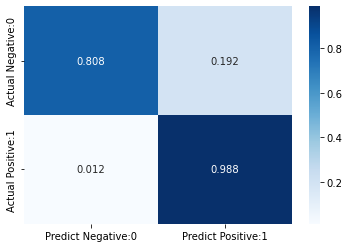

In [32]:
plot_confusion_matrix(y_test_current,y_pred_current)

In [33]:
get_metrics(y_test_current,y_pred_current)

Accuracy:  0.9502
F1 score:  0.9691
Recall:  0.9878
Precision:  0.9511


## Using Vibration data

In [18]:
# Split train and test
X_train_vib = train_df.filter(like="vib")
X_test_vib = test_df.filter(like="vib")

y_train_vib = train_df['label'].values
y_test_vib = test_df['label'].values

# scaler
scaler = StandardScaler()

X_train_vib = scaler.fit_transform(X_train_vib)

X_test_vib = scaler.transform(X_test_vib)

In [19]:
# get best combination of number of neurons
title_best_vib = "ssa_l20_n5_vib"
best_vib = get_nn(X_train_vib,y_train_vib,title_best_vib)

4 neurons on first layer and 4 on second layer


c:\Users\julia\.julia\conda\3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


accuracy of: 0.993 for 4 and 4 neurons (1st and 2nd layer)
4 neurons on first layer and 8 on second layer
accuracy of: 0.982 for 4 and 8 neurons (1st and 2nd layer)
4 neurons on first layer and 16 on second layer
accuracy of: 0.983 for 4 and 16 neurons (1st and 2nd layer)
4 neurons on first layer and 32 on second layer
accuracy of: 0.975 for 4 and 32 neurons (1st and 2nd layer)
4 neurons on first layer and 64 on second layer
accuracy of: 0.988 for 4 and 64 neurons (1st and 2nd layer)
4 neurons on first layer and 128 on second layer
accuracy of: 0.889 for 4 and 128 neurons (1st and 2nd layer)
8 neurons on first layer and 4 on second layer
accuracy of: 0.99 for 8 and 4 neurons (1st and 2nd layer)
8 neurons on first layer and 8 on second layer
accuracy of: 0.99 for 8 and 8 neurons (1st and 2nd layer)
8 neurons on first layer and 16 on second layer
accuracy of: 0.99 for 8 and 16 neurons (1st and 2nd layer)
8 neurons on first layer and 32 on second layer
accuracy of: 0.993 for 8 and 32 neur

In [20]:
best_vib.sort_values('accuracy',ascending=False).head()

,accuracy,neurons_1st,neurons_2nd
28,0.996176,64,64
23,0.996029,32,128
22,0.995588,32,64
20,0.995441,32,16
26,0.995441,64,16


### Results of the best estimator

In [34]:
model_vib = load_model(f"{title_best_vib}.hdf5")

y_pred_vib = model_vib.predict(X_test_vib) > 0.5

print(classification_report(y_test_vib, y_pred_vib))

108/108 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       720
           1       0.96      0.95      0.96      2716

    accuracy                           0.93      3436
   macro avg       0.89      0.91      0.90      3436
weighted avg       0.93      0.93      0.93      3436



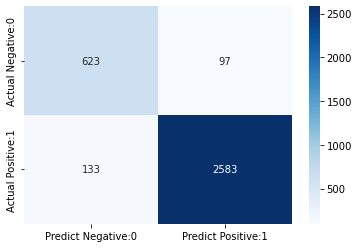

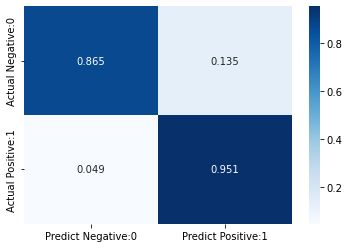

In [35]:
plot_confusion_matrix(y_test_vib, y_pred_vib)

In [36]:
get_metrics(y_test_vib,y_pred_vib)

Accuracy:  0.9331
F1 score:  0.9574
Recall:  0.951
Precision:  0.9638


## Using all data

In [24]:
X_train_all = train_df.drop(columns= {'rotation_speed', 'load_torque',
       'radial_force', 'bearing', 'label', 'label_detailed','category'})
X_test_all = test_df.drop(columns= {'rotation_speed', 'load_torque',
       'radial_force', 'bearing', 'label', 'label_detailed','category'})
y_train_all = train_df['label'].values
y_test_all = test_df['label'].values

# scaler
scaler = StandardScaler()

X_train_all = scaler.fit_transform(X_train_all)

X_test_all = scaler.transform(X_test_all)

In [25]:
# get best combination of number of neurons
title_best_all = "ssa_l20_n5_all"
best_all = get_nn(X_train_all,y_train_all,title_best_all)

4 neurons on first layer and 4 on second layer


c:\Users\julia\.julia\conda\3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


accuracy of: 0.996 for 4 and 4 neurons (1st and 2nd layer)
4 neurons on first layer and 8 on second layer
accuracy of: 0.999 for 4 and 8 neurons (1st and 2nd layer)
4 neurons on first layer and 16 on second layer
accuracy of: 1.0 for 4 and 16 neurons (1st and 2nd layer)
4 neurons on first layer and 32 on second layer
accuracy of: 1.0 for 4 and 32 neurons (1st and 2nd layer)
4 neurons on first layer and 64 on second layer
accuracy of: 0.995 for 4 and 64 neurons (1st and 2nd layer)
4 neurons on first layer and 128 on second layer
accuracy of: 0.999 for 4 and 128 neurons (1st and 2nd layer)
8 neurons on first layer and 4 on second layer
accuracy of: 1.0 for 8 and 4 neurons (1st and 2nd layer)
8 neurons on first layer and 8 on second layer
accuracy of: 1.0 for 8 and 8 neurons (1st and 2nd layer)
8 neurons on first layer and 16 on second layer
accuracy of: 1.0 for 8 and 16 neurons (1st and 2nd layer)
8 neurons on first layer and 32 on second layer
accuracy of: 0.999 for 8 and 32 neurons (1s

In [26]:
best_all.sort_values('accuracy',ascending=False).head()

,accuracy,neurons_1st,neurons_2nd
21,0.999853,32,32
33,0.999853,128,32
14,0.999853,16,16
8,0.999853,8,16
12,0.999853,16,4


### Resuls of best estimator

In [37]:
model_all = load_model(f"{title_best_all}.hdf5")

y_pred_all = model_all.predict(X_test_all) > 0.5

print(classification_report(y_test_all, y_pred_all))

108/108 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       720
           1       0.97      0.99      0.98      2716

    accuracy                           0.97      3436
   macro avg       0.96      0.94      0.95      3436
weighted avg       0.97      0.97      0.97      3436



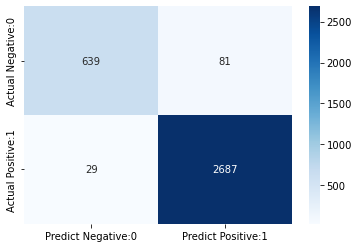

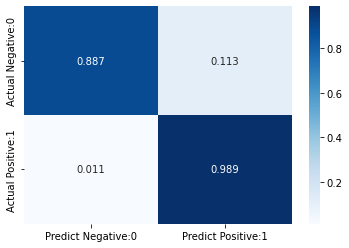

In [38]:
plot_confusion_matrix(y_test_all, y_pred_all)

In [39]:
get_metrics(y_test_all, y_pred_all)

Accuracy:  0.968
F1 score:  0.9799
Recall:  0.9893
Precision:  0.9707
